In [2]:
import pdfplumber
import re
import pandas as pd
from io import StringIO
import time  # Import the time module

# Start timing
start_time = time.time()

# the PDF
pdf = pdfplumber.open("19398DP12019Roster.pdf")

# Initialize an empty list to store all rows
all_rows = []

# Iterate over each page in the PDF (219 pages total)
for page in pdf.pages:
    text = page.extract_text(keep_blank_chars=True)
    # regex
    # core_pat is "core pattern" and it says to capture... 
    # everything after "at least 5 hyphens, spaces, and a line break"
    core_pat = re.compile(r"-{5,}\s*\n(.*)", re.DOTALL)
    match = re.search(core_pat, text)

    if match:
        core = match.group(1) # group(1) is the (.*) part of the regex, it's everything under the hyphens

        # Convert the text data into a StringIO object
        data_io = StringIO(core)
        
        # More regex to match the required fields
        
        #(?P<name>.*?): Captures any characters (the name) up until the first digit, using a non-greedy match.
        #(?P<number>\d{5}): Captures exactly five digits (the number).
        #(?P<rank>.{1,9}): Captures the next up to 9 characters (the rank).
        #(?P<area>.{1,7}): Captures the next up to 7 characters (the area).
        #(?P<sex>[MF]): Captures either "M" or "F" (the sex). (assuming only M&F from scrolling through PDF)
        #(?P<ethnicity>.+)$: Captures the remainder of the line (the ethnicity).
        pattern = r"^(?P<name>.*?)(?P<number>\d{5})\s+(?P<rank>.{1,9})\s+(?P<area>.{1,7})\s+(?P<sex>[MF])\s+(?P<ethnicity>.+)$"

        # Read the data into a DataFrame
        # parse it line-by-line (perhaps not the most efficient way of doing this?)
        for line in core.strip().split("\n"):
            match = re.match(pattern, line) # the long pattern above, goes here
            if match:
                name = match.group("name").strip()
                number = match.group("number").strip()  # Keep number as string
                rank = match.group("rank").strip()
                area = match.group("area").strip()
                sex = match.group("sex").strip()
                ethnicity = match.group("ethnicity").strip()

                # Append the extracted values to all_rows
                all_rows.append([name, number, rank, area, sex, ethnicity])

# Create the DataFrame from all rows
columns = ["Name", "Number", "Rank", "Area", "Sex", "Ethnicity"]
df = pd.DataFrame(all_rows, columns=columns)

# Close the PDF
pdf.close()

# Output the DataFrame to .csv in the project's directory
csv_filename = "output.csv"
df.to_csv(csv_filename, index=False)
# message that the .csv output was successful
print(f"DataFrame exported to {csv_filename}")

# Calculate duration
end_time = time.time()
duration = end_time - start_time
num_pages = len(pdf.pages)
print(f"{num_pages} pages of PDF extracted in {duration:.2f} seconds.")


DataFrame exported to output.csv
219 pages of PDF extracted in 16.16 seconds.


In [3]:
# Count the occurrences of M and F
sex_counts = df['Sex'].value_counts()

# Calculate percentages
total_count = len(df)
percent_m = (sex_counts.get('M', 0) / total_count) * 100
percent_f = (sex_counts.get('F', 0) / total_count) * 100

# Summary
summary_sex = {
    'Count M': sex_counts.get('M', 0),
    'Count F': sex_counts.get('F', 0),
    'Percent M': percent_m,
    'Percent F': percent_f
}

print("Summary by Sex:")
print(summary_sex)

Summary by Sex:
{'Count M': 8183, 'Count F': 1849, 'Percent M': 81.56897926634768, 'Percent F': 18.43102073365231}


In [4]:
# Group by Sex and Rank, counting occurrences
sex_rank_counts = df.groupby(['Sex', 'Rank']).size().unstack(fill_value=0)

print("\nCounts by Sex and Rank:")
print(sex_rank_counts)



Counts by Sex and Rank:
Rank  AC  CAPT 1  CAPT 2  CAPT 3  CMDR  COP  DEP CHF  DET 1  DET 2  DET 3  \
Sex                                                                         
F      1       3       4       6     4    0        2    139    158     90   
M      2      19      13      31    18    1        8    456    451    228   

Rank  ...  MCAPT 1  MCAPT 2  MPO  MSGT  PO 1  PO 2  PO 3  PO SPEC  SGT 1  \
Sex   ...                                                                  
F     ...        0        0    2     1   138   621   428        0    134   
M     ...        1        1   20     2   501  3302  1857        4    662   

Rank  SGT 2  
Sex          
F        66  
M       379  

[2 rows x 22 columns]


In [66]:
# Group by Rank and Sex, counting occurrences
rank_sex_counts = df.groupby(['Rank', 'Sex']).size().unstack(fill_value=0)

# Calculate the total counts for each rank
rank_totals = rank_sex_counts.sum(axis=1)

# Calculate the percentages
rank_percentages = rank_sex_counts.divide(rank_totals, axis=0) * 100

# Round percentages to 1 decimal place
rank_percentages = rank_percentages.round(1)

# Rename columns for clarity
rank_percentages.columns = [f'Percent {sex}' for sex in rank_percentages.columns]

# Combine counts and percentages into a single DataFrame
result = pd.concat([rank_sex_counts, rank_percentages], axis=1)

# Rename columns for counts
result.columns = [f'Count {sex}' for sex in rank_sex_counts.columns] + list(rank_percentages.columns)

# Sort by Percent M in descending order
result = result.sort_values(by='Percent M', ascending=False)

# Create a new column with '*' if Count M + Count F >= 100
result[''] = result.apply(lambda row: '*' if (row['Count M'] + row['Count F']) >= 100 else '', axis=1)

# Reorder columns to make 'Star' the first column
result = result[[''] + [col for col in result.columns if col != '']]

print("\nTotal Count and Percent of M and F for Each Rank: \n * means M + F for that rank > 100")
print(result)


Total Count and Percent of M and F for Each Rank: 
 * means M + F for that rank > 100
            Count F  Count M  Percent F  Percent M
Rank                                              
PO SPEC           0        4        0.0      100.0
COP               0        1        0.0      100.0
MCAPT 2           0        1        0.0      100.0
MCAPT 1           0        1        0.0      100.0
MPO               2       20        9.1       90.9
CAPT 1            3       19       13.6       86.4
SGT 2    *       66      379       14.8       85.2
PO 2     *      621     3302       15.8       84.2
CAPT 3            6       31       16.2       83.8
SGT 1    *      134      662       16.8       83.2
LT 2     *       30      138       17.9       82.1
CMDR              4       18       18.2       81.8
PO 3     *      428     1857       18.7       81.3
LT 1     *       22       89       19.8       80.2
DEP CHF           2        8       20.0       80.0
PO 1     *      138      501       21.6       

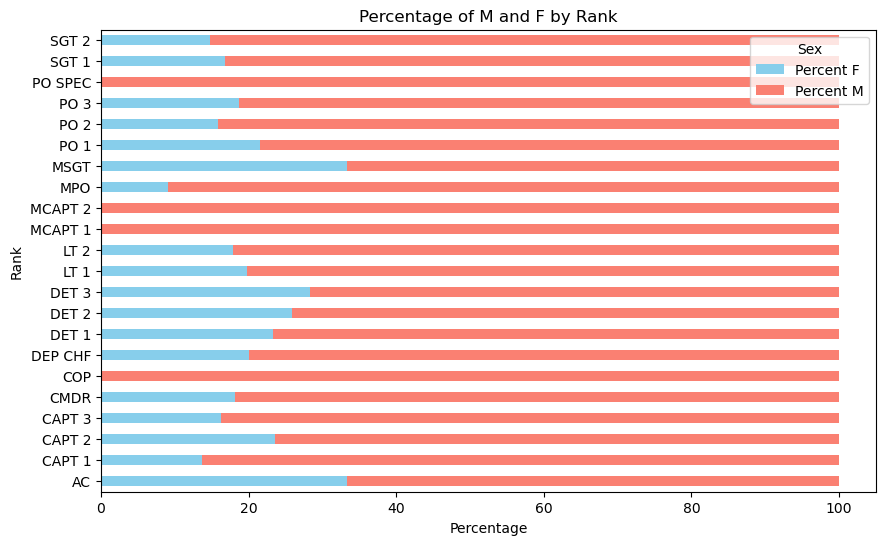

In [8]:
import matplotlib.pyplot as plt

# Assuming 'result' contains the counts and percentages
# Prepare the data for plotting
percent_data = result.filter(like='Percent')

# Plotting
ax = percent_data.plot(kind='barh', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])

# Adding labels and title
ax.set_xlabel('Percentage')
ax.set_ylabel('Rank')
ax.set_title('Percentage of M and F by Rank')
ax.legend(title='Sex', loc='upper right')

# Show the plot
plt.show()

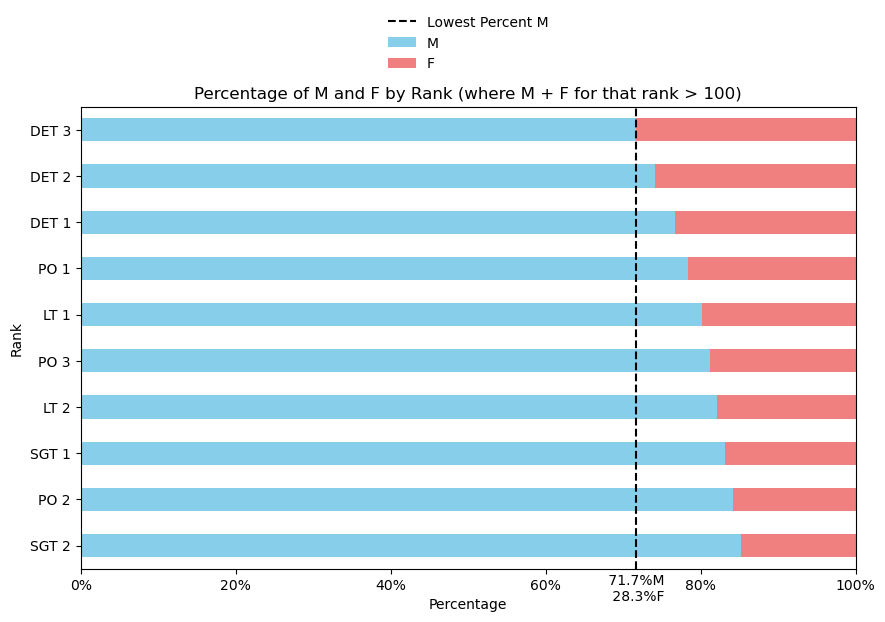

In [64]:
import matplotlib.ticker as mticker

# Prepare the data for plotting
percent_data = sorted_result.filter(like='Percent')

# Create a new DataFrame with both percentages
percent_data_combined = pd.DataFrame({
    'M': percent_data['Percent M'],
    'F': percent_data['Percent F']
})

# Plotting with F stacked on top of M
ax = percent_data_combined.plot(kind='barh', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'])

# Adding a vertical line at the lowest percent M
lowest_percent_m = percent_data['Percent M'].min()
highest_percent_f = 100 - lowest_percent_m
ax.axvline(lowest_percent_m, color='black', linestyle='--', label='Lowest Percent M')

# Formatting x-axis labels as percentages
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))  # Set xmax to 100 for percent formatting
ax.set_xlim(0, 100)  # Set limits for 0% to 100%

# Adding the caption below the x-axis labels
ax.text(lowest_percent_m, -.6, f' {lowest_percent_m:.1f}%M \n {highest_percent_f:.1f}%F', 
        color='black', ha='center', va='top', fontsize=10)

# Adding labels and title
ax.set_xlabel('Percentage')
ax.set_ylabel('Rank')
ax.set_title('Percentage of M and F by Rank (where M + F for that rank > 100)')
ax.legend(title='', loc='lower center', bbox_to_anchor=(0.5, 1.05), frameon=False)

# Show the plot
plt.show()